In [27]:
%load_ext autoreload
%autoreload 2

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations import *
from torchvision import transforms
from torch.utils.data import DataLoader
from glob import glob
import segmentation_models_pytorch as smp

import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 

import wandb
import logging
from tqdm import tqdm

# load dataset 
import dataset_rs
import utils_rs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
#-- data
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/03.data_list/512_ships.npy")

selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

#-- category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)}

In [29]:
dataset = dataset_rs.Seg_RS_dataset_ship(img_dir=selected_paths_img, mask_dir=selected_paths_mask, image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP )

In [30]:
img,label = dataset.__getitem__(20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


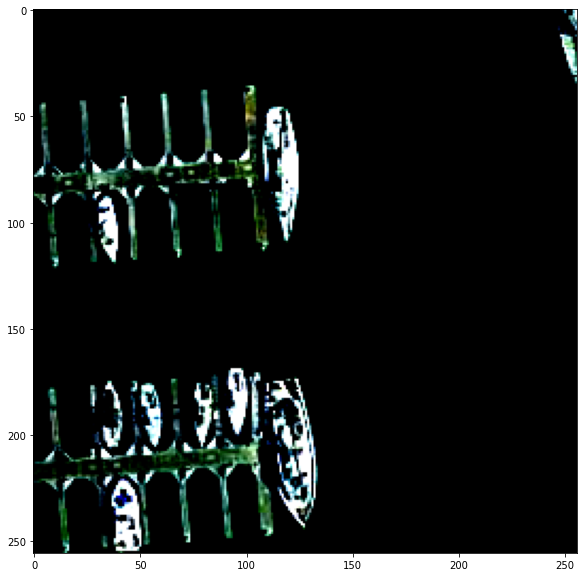

In [31]:
utils_rs.torch_display(img)

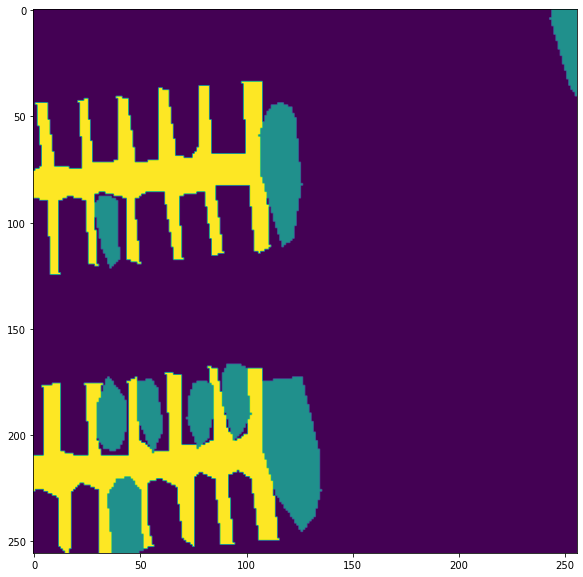

In [32]:
label_ = label.unsqueeze(-1)
plt.figure(figsize=(10,10))
plt.imshow(label_)

In [33]:
model = smp.UnetPlusPlus(
    encoder_name="resnet152",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [34]:
tgt_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/02.ckpts"
ckpt_path = os.path.join( tgt_path, sorted(os.listdir(tgt_path))[-1]  )
print(ckpt_path)

/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/02.ckpts/ver_23_epoch_81.pt


In [35]:
device = "cpu"
checkpoint = torch.load(ckpt_path, map_location=device)
#model = UNet(num_classes=num_classes)
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()

In [36]:
img_ = img.unsqueeze(0)
pred = model(img_)

In [37]:
pred_mask = torch.argmax(pred, dim=1)

In [38]:
pred_mask.shape

torch.Size([1, 256, 256])

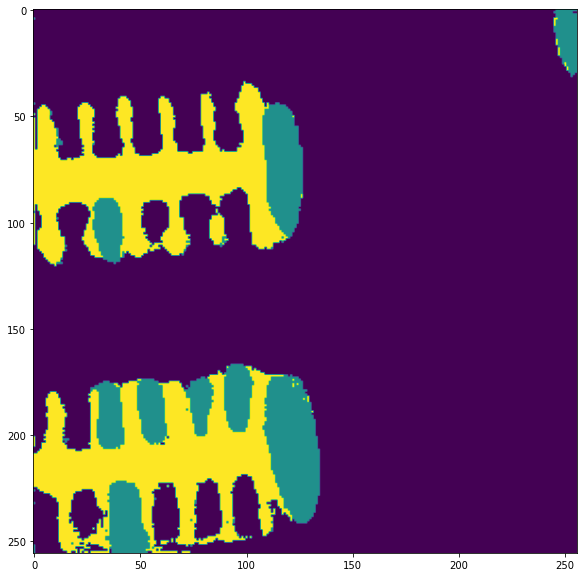

In [39]:
utils_rs.torch_display(pred_mask)